In [1]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F  
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import cv2
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
import sys
import time
from PIL import Image

In [2]:
torch.manual_seed(1220)
random.seed(1220)
np.random.seed(1220)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

path_dataset = "./resized/beam_resize"

You are using device: cuda


In [5]:
def load_dataset(path_dataset):
    imagenet_stats = [(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)]

    train_transform = transforms.Compose([
        transforms.RandomResizedCrop((400, 400)),  
        transforms.CenterCrop((350, 350)),
        transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        # transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_stats[0], imagenet_stats[1])
    ])

    val_transform = transforms.Compose([
        transforms.CenterCrop((400, 400)),
        transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation(10),
        # transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_stats[0], imagenet_stats[1])
    ])

    full_dataset = torchvision.datasets.ImageFolder(root=path_dataset)
    classes = full_dataset.classes
    print(classes)
    dataset_size = len(full_dataset)
    train_size = int(0.85 * dataset_size)
    val_size = dataset_size - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_transform
    
    train_loader = DataLoader(
        train_dataset, batch_size=32, shuffle=True, num_workers=4
    )
    
    val_loader = DataLoader(
        val_dataset, batch_size=32, shuffle=False, num_workers=4
    )

    return train_loader, val_loader, classes

train_loader, val_loader, classes = load_dataset(path_dataset)

# model_ = torchvision.models.resnet18(weights='IMAGENET1K_V1')
# model_.fc = nn.Sequential(
#     nn.Linear(model_.fc.in_features, len(classes)),
#     nn.Sigmoid()
# )

model_ = torchvision.models.shufflenet_v2_x1_5(weights='IMAGENET1K_V1')
model_.fc = nn.Sequential(
    nn.Linear(model_.fc.in_features, len(classes)),
    nn.Sigmoid()
)

['Diagonal', 'Horizontal', 'Vertical', 'Web']


In [6]:
if torch.cuda.is_available():
    model_.cuda()
from torchsummary import summary
summary(model_, (3, 400, 400))
print(model_)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 200, 200]             648
       BatchNorm2d-2         [-1, 24, 200, 200]              48
              ReLU-3         [-1, 24, 200, 200]               0
         MaxPool2d-4         [-1, 24, 100, 100]               0
            Conv2d-5           [-1, 24, 50, 50]             216
       BatchNorm2d-6           [-1, 24, 50, 50]              48
            Conv2d-7           [-1, 88, 50, 50]           2,112
       BatchNorm2d-8           [-1, 88, 50, 50]             176
              ReLU-9           [-1, 88, 50, 50]               0
           Conv2d-10         [-1, 88, 100, 100]           2,112
      BatchNorm2d-11         [-1, 88, 100, 100]             176
             ReLU-12         [-1, 88, 100, 100]               0
           Conv2d-13           [-1, 88, 50, 50]             792
      BatchNorm2d-14           [-1, 88,

In [7]:
def train(model, trainloader, valloader, epochs=10):
    torch.cuda.empty_cache()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    # scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, eta_min=1e-7)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=32)
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_val_acc = 80
    best_val_loss = 0
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Wrap trainloader with tqdm for progress bar to make it looks nicer
        loop = tqdm(enumerate(trainloader), total=len(trainloader), leave=True)
        for i, data in loop:
            # Get inputs and labels
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update running loss
            running_loss += loss.item()
            
            # Update progress bar
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=running_loss/(i+1), accuracy=100.*correct/total)
        
        
        # Calculate epoch statistics for training
        epoch_train_loss = running_loss / len(trainloader)
        epoch_train_acc = 100. * correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                # Calculate validation loss
                val_running_loss += loss.item()
                
                # Calculate validation accuracy
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        # Calculate epoch statistics for validation
        epoch_val_loss = val_running_loss / len(valloader)
        epoch_val_acc = 100. * val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_val_loss = epoch_val_loss
            torch.save(model_.state_dict(), 'model.pth')
            print(best_val_acc, best_val_loss)
        elif epoch_val_acc == best_val_acc:
            if epoch_val_loss < best_val_loss:
                torch.save(model_.state_dict(), 'model.pth')
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%")
        print(f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
        print("-" * 60)
    
    print('Finished Training')
    
    return model, train_losses, train_accuracies, val_losses, val_accuracies

def evaluate(model, valloader):

    model.eval()
    correct = 0
    total = 0
    
    # Initialize lists for per-class accuracy
    num_classes = len(classes)
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))
    
    # Initialize confusion matrix
    confusion_matrix = torch.zeros(num_classes, num_classes)
    
    with torch.no_grad():
        for data in tqdm(valloader, desc="Evaluating"):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Calculate per-class accuracy
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
                
                # Update confusion matrix
                confusion_matrix[label, predicted[i]] += 1

    overall_accuracy = 100 * correct / total
    print(f'Overall Accuracy: {overall_accuracy:.2f}%')

    
    return class_correct, class_total, confusion_matrix

In [8]:
print("Starting training...")
# model_.load_state_dict(torch.load('model.pth', map_location=device))
# for param in model_.parameters():
#     param.requires_grad = True
trained_model, train_losses, train_accuracies, val_losses, val_accuracies = train(
    model_, train_loader, val_loader, epochs=150
)

Starting training...


Epoch [1/150]: 100%|██████████| 18/18 [00:06<00:00,  2.72it/s, accuracy=52.9, loss=1.35]


Epoch 1/150
Train Loss: 1.3542, Train Acc: 52.86%
Val Loss: 1.3371, Val Acc: 72.73%
------------------------------------------------------------


Epoch [2/150]: 100%|██████████| 18/18 [00:05<00:00,  3.16it/s, accuracy=75.2, loss=1.3]


Epoch 2/150
Train Loss: 1.2988, Train Acc: 75.18%
Val Loss: 1.2947, Val Acc: 67.68%
------------------------------------------------------------


Epoch [3/150]: 100%|██████████| 18/18 [00:05<00:00,  3.25it/s, accuracy=75.4, loss=1.28]


Epoch 3/150
Train Loss: 1.2830, Train Acc: 75.36%
Val Loss: 1.2452, Val Acc: 70.71%
------------------------------------------------------------


Epoch [4/150]: 100%|██████████| 18/18 [00:05<00:00,  3.18it/s, accuracy=76.6, loss=1.19]


Epoch 4/150
Train Loss: 1.1863, Train Acc: 76.61%
Val Loss: 1.1020, Val Acc: 72.73%
------------------------------------------------------------


Epoch [5/150]: 100%|██████████| 18/18 [00:05<00:00,  3.20it/s, accuracy=77, loss=1.09]  


Epoch 5/150
Train Loss: 1.0863, Train Acc: 76.96%
Val Loss: 1.0633, Val Acc: 74.75%
------------------------------------------------------------


Epoch [6/150]: 100%|██████████| 18/18 [00:05<00:00,  3.10it/s, accuracy=76.6, loss=1.07]


Epoch 6/150
Train Loss: 1.0729, Train Acc: 76.61%
Val Loss: 1.0590, Val Acc: 72.73%
------------------------------------------------------------


Epoch [7/150]: 100%|██████████| 18/18 [00:05<00:00,  3.12it/s, accuracy=77.9, loss=1.06]


Epoch 7/150
Train Loss: 1.0551, Train Acc: 77.86%
Val Loss: 1.0151, Val Acc: 74.75%
------------------------------------------------------------


Epoch [8/150]: 100%|██████████| 18/18 [00:05<00:00,  3.20it/s, accuracy=78.4, loss=1]   


Epoch 8/150
Train Loss: 1.0031, Train Acc: 78.39%
Val Loss: 0.9727, Val Acc: 75.76%
------------------------------------------------------------


Epoch [9/150]: 100%|██████████| 18/18 [00:05<00:00,  3.13it/s, accuracy=81.2, loss=0.974]


Epoch 9/150
Train Loss: 0.9736, Train Acc: 81.25%
Val Loss: 0.9755, Val Acc: 74.75%
------------------------------------------------------------


Epoch [10/150]: 100%|██████████| 18/18 [00:05<00:00,  3.12it/s, accuracy=81.6, loss=0.979]


Epoch 10/150
Train Loss: 0.9794, Train Acc: 81.61%
Val Loss: 0.9665, Val Acc: 76.77%
------------------------------------------------------------


Epoch [11/150]: 100%|██████████| 18/18 [00:05<00:00,  3.12it/s, accuracy=82.5, loss=0.955]


Epoch 11/150
Train Loss: 0.9549, Train Acc: 82.50%
Val Loss: 0.9579, Val Acc: 75.76%
------------------------------------------------------------


Epoch [12/150]: 100%|██████████| 18/18 [00:05<00:00,  3.17it/s, accuracy=83.2, loss=0.935]


Epoch 12/150
Train Loss: 0.9354, Train Acc: 83.21%
Val Loss: 0.9423, Val Acc: 76.77%
------------------------------------------------------------


Epoch [13/150]: 100%|██████████| 18/18 [00:05<00:00,  3.20it/s, accuracy=83.9, loss=0.928]


Epoch 13/150
Train Loss: 0.9276, Train Acc: 83.93%
Val Loss: 0.9425, Val Acc: 74.75%
------------------------------------------------------------


Epoch [14/150]: 100%|██████████| 18/18 [00:05<00:00,  3.15it/s, accuracy=85.4, loss=0.92] 


Epoch 14/150
Train Loss: 0.9196, Train Acc: 85.36%
Val Loss: 0.9313, Val Acc: 75.76%
------------------------------------------------------------


Epoch [15/150]: 100%|██████████| 18/18 [00:05<00:00,  3.18it/s, accuracy=86.2, loss=0.901]


Epoch 15/150
Train Loss: 0.9012, Train Acc: 86.25%
Val Loss: 0.9221, Val Acc: 74.75%
------------------------------------------------------------


Epoch [16/150]: 100%|██████████| 18/18 [00:05<00:00,  3.19it/s, accuracy=88.2, loss=0.887]


Epoch 16/150
Train Loss: 0.8868, Train Acc: 88.21%
Val Loss: 0.9130, Val Acc: 77.78%
------------------------------------------------------------


Epoch [17/150]: 100%|██████████| 18/18 [00:05<00:00,  3.20it/s, accuracy=87.1, loss=0.901]


Epoch 17/150
Train Loss: 0.9008, Train Acc: 87.14%
Val Loss: 0.9270, Val Acc: 76.77%
------------------------------------------------------------


Epoch [18/150]: 100%|██████████| 18/18 [00:05<00:00,  3.20it/s, accuracy=88.8, loss=0.881]


Epoch 18/150
Train Loss: 0.8811, Train Acc: 88.75%
Val Loss: 0.9127, Val Acc: 75.76%
------------------------------------------------------------


Epoch [19/150]: 100%|██████████| 18/18 [00:05<00:00,  3.19it/s, accuracy=89.8, loss=0.873]


Epoch 19/150
Train Loss: 0.8731, Train Acc: 89.82%
Val Loss: 0.9144, Val Acc: 76.77%
------------------------------------------------------------


Epoch [20/150]: 100%|██████████| 18/18 [00:05<00:00,  3.20it/s, accuracy=90.7, loss=0.857]


Epoch 20/150
Train Loss: 0.8565, Train Acc: 90.71%
Val Loss: 0.9146, Val Acc: 77.78%
------------------------------------------------------------


Epoch [21/150]: 100%|██████████| 18/18 [00:05<00:00,  3.20it/s, accuracy=91.8, loss=0.846]


Epoch 21/150
Train Loss: 0.8458, Train Acc: 91.79%
Val Loss: 0.9108, Val Acc: 77.78%
------------------------------------------------------------


Epoch [22/150]: 100%|██████████| 18/18 [00:05<00:00,  3.20it/s, accuracy=92.3, loss=0.85] 


Epoch 22/150
Train Loss: 0.8496, Train Acc: 92.32%
Val Loss: 0.9143, Val Acc: 74.75%
------------------------------------------------------------


Epoch [23/150]: 100%|██████████| 18/18 [00:05<00:00,  3.20it/s, accuracy=92.9, loss=0.838]


Epoch 23/150
Train Loss: 0.8384, Train Acc: 92.86%
Val Loss: 0.9080, Val Acc: 77.78%
------------------------------------------------------------


Epoch [24/150]: 100%|██████████| 18/18 [00:05<00:00,  3.19it/s, accuracy=92.5, loss=0.84] 


Epoch 24/150
Train Loss: 0.8395, Train Acc: 92.50%
Val Loss: 0.8991, Val Acc: 75.76%
------------------------------------------------------------


Epoch [25/150]: 100%|██████████| 18/18 [00:05<00:00,  3.15it/s, accuracy=92.5, loss=0.841]


Epoch 25/150
Train Loss: 0.8412, Train Acc: 92.50%
Val Loss: 0.9086, Val Acc: 76.77%
------------------------------------------------------------


Epoch [26/150]: 100%|██████████| 18/18 [00:05<00:00,  3.19it/s, accuracy=93.8, loss=0.825]


Epoch 26/150
Train Loss: 0.8245, Train Acc: 93.75%
Val Loss: 0.8994, Val Acc: 78.79%
------------------------------------------------------------


Epoch [27/150]: 100%|██████████| 18/18 [00:05<00:00,  3.20it/s, accuracy=94.5, loss=0.826]


Epoch 27/150
Train Loss: 0.8261, Train Acc: 94.46%
Val Loss: 0.8950, Val Acc: 78.79%
------------------------------------------------------------


Epoch [28/150]: 100%|██████████| 18/18 [00:05<00:00,  3.19it/s, accuracy=95.2, loss=0.809]


Epoch 28/150
Train Loss: 0.8093, Train Acc: 95.18%
Val Loss: 0.8994, Val Acc: 79.80%
------------------------------------------------------------


Epoch [29/150]: 100%|██████████| 18/18 [00:05<00:00,  3.11it/s, accuracy=94.6, loss=0.817]


Epoch 29/150
Train Loss: 0.8166, Train Acc: 94.64%
Val Loss: 0.9042, Val Acc: 77.78%
------------------------------------------------------------


Epoch [30/150]: 100%|██████████| 18/18 [00:05<00:00,  3.10it/s, accuracy=96.2, loss=0.804]


Epoch 30/150
Train Loss: 0.8036, Train Acc: 96.25%
Val Loss: 0.8996, Val Acc: 77.78%
------------------------------------------------------------


Epoch [31/150]: 100%|██████████| 18/18 [00:05<00:00,  3.14it/s, accuracy=95.9, loss=0.802]


Epoch 31/150
Train Loss: 0.8020, Train Acc: 95.89%
Val Loss: 0.9027, Val Acc: 74.75%
------------------------------------------------------------


Epoch [32/150]: 100%|██████████| 18/18 [00:05<00:00,  3.19it/s, accuracy=96.4, loss=0.796]


80.8080808080808 0.8860406279563904
Epoch 32/150
Train Loss: 0.7959, Train Acc: 96.43%
Val Loss: 0.8860, Val Acc: 80.81%
------------------------------------------------------------


Epoch [33/150]: 100%|██████████| 18/18 [00:05<00:00,  3.14it/s, accuracy=96.6, loss=0.793]


82.82828282828282 0.8858595192432404
Epoch 33/150
Train Loss: 0.7930, Train Acc: 96.61%
Val Loss: 0.8859, Val Acc: 82.83%
------------------------------------------------------------


Epoch [34/150]: 100%|██████████| 18/18 [00:05<00:00,  3.15it/s, accuracy=97.7, loss=0.786]


Epoch 34/150
Train Loss: 0.7861, Train Acc: 97.68%
Val Loss: 0.8909, Val Acc: 81.82%
------------------------------------------------------------


Epoch [35/150]: 100%|██████████| 18/18 [00:05<00:00,  3.10it/s, accuracy=97, loss=0.792]  


Epoch 35/150
Train Loss: 0.7922, Train Acc: 96.96%
Val Loss: 0.8952, Val Acc: 78.79%
------------------------------------------------------------


Epoch [36/150]: 100%|██████████| 18/18 [00:05<00:00,  3.22it/s, accuracy=97.1, loss=0.79] 


Epoch 36/150
Train Loss: 0.7896, Train Acc: 97.14%
Val Loss: 0.8898, Val Acc: 82.83%
------------------------------------------------------------


Epoch [37/150]: 100%|██████████| 18/18 [00:05<00:00,  3.03it/s, accuracy=97, loss=0.781]  


83.83838383838383 0.8889566659927368
Epoch 37/150
Train Loss: 0.7811, Train Acc: 96.96%
Val Loss: 0.8890, Val Acc: 83.84%
------------------------------------------------------------


Epoch [38/150]: 100%|██████████| 18/18 [00:05<00:00,  3.01it/s, accuracy=97.5, loss=0.78] 


Epoch 38/150
Train Loss: 0.7796, Train Acc: 97.50%
Val Loss: 0.8830, Val Acc: 81.82%
------------------------------------------------------------


Epoch [39/150]: 100%|██████████| 18/18 [00:05<00:00,  3.06it/s, accuracy=97.9, loss=0.779]


Epoch 39/150
Train Loss: 0.7789, Train Acc: 97.86%
Val Loss: 0.8948, Val Acc: 78.79%
------------------------------------------------------------


Epoch [40/150]: 100%|██████████| 18/18 [00:05<00:00,  3.13it/s, accuracy=97.9, loss=0.779]


Epoch 40/150
Train Loss: 0.7792, Train Acc: 97.86%
Val Loss: 0.8878, Val Acc: 81.82%
------------------------------------------------------------


Epoch [41/150]: 100%|██████████| 18/18 [00:05<00:00,  3.14it/s, accuracy=97.9, loss=0.772]


Epoch 41/150
Train Loss: 0.7725, Train Acc: 97.86%
Val Loss: 0.8801, Val Acc: 82.83%
------------------------------------------------------------


Epoch [42/150]: 100%|██████████| 18/18 [00:06<00:00,  2.98it/s, accuracy=98.4, loss=0.768]


Epoch 42/150
Train Loss: 0.7681, Train Acc: 98.39%
Val Loss: 0.8689, Val Acc: 83.84%
------------------------------------------------------------


Epoch [43/150]: 100%|██████████| 18/18 [00:05<00:00,  3.12it/s, accuracy=98, loss=0.778]  


Epoch 43/150
Train Loss: 0.7776, Train Acc: 98.04%
Val Loss: 0.8734, Val Acc: 81.82%
------------------------------------------------------------


Epoch [44/150]: 100%|██████████| 18/18 [00:05<00:00,  3.11it/s, accuracy=98.4, loss=0.774]


Epoch 44/150
Train Loss: 0.7741, Train Acc: 98.39%
Val Loss: 0.8803, Val Acc: 82.83%
------------------------------------------------------------


Epoch [45/150]: 100%|██████████| 18/18 [00:05<00:00,  3.12it/s, accuracy=98.2, loss=0.769]


84.84848484848484 0.8707080781459808
Epoch 45/150
Train Loss: 0.7693, Train Acc: 98.21%
Val Loss: 0.8707, Val Acc: 84.85%
------------------------------------------------------------


Epoch [46/150]: 100%|██████████| 18/18 [00:05<00:00,  3.06it/s, accuracy=98.8, loss=0.772]


Epoch 46/150
Train Loss: 0.7725, Train Acc: 98.75%
Val Loss: 0.8821, Val Acc: 82.83%
------------------------------------------------------------


Epoch [47/150]: 100%|██████████| 18/18 [00:05<00:00,  3.13it/s, accuracy=98.6, loss=0.773]


Epoch 47/150
Train Loss: 0.7726, Train Acc: 98.57%
Val Loss: 0.8716, Val Acc: 81.82%
------------------------------------------------------------


Epoch [48/150]: 100%|██████████| 18/18 [00:05<00:00,  3.15it/s, accuracy=99.3, loss=0.767]


Epoch 48/150
Train Loss: 0.7674, Train Acc: 99.29%
Val Loss: 0.8762, Val Acc: 80.81%
------------------------------------------------------------


Epoch [49/150]: 100%|██████████| 18/18 [00:05<00:00,  3.19it/s, accuracy=99.1, loss=0.763]


Epoch 49/150
Train Loss: 0.7626, Train Acc: 99.11%
Val Loss: 0.8684, Val Acc: 82.83%
------------------------------------------------------------


Epoch [50/150]: 100%|██████████| 18/18 [00:05<00:00,  3.19it/s, accuracy=99.1, loss=0.762]


Epoch 50/150
Train Loss: 0.7620, Train Acc: 99.11%
Val Loss: 0.8742, Val Acc: 83.84%
------------------------------------------------------------


Epoch [51/150]: 100%|██████████| 18/18 [00:05<00:00,  3.17it/s, accuracy=98.4, loss=0.768]


Epoch 51/150
Train Loss: 0.7684, Train Acc: 98.39%
Val Loss: 0.8818, Val Acc: 82.83%
------------------------------------------------------------


Epoch [52/150]: 100%|██████████| 18/18 [00:05<00:00,  3.20it/s, accuracy=99.1, loss=0.76] 


Epoch 52/150
Train Loss: 0.7603, Train Acc: 99.11%
Val Loss: 0.8637, Val Acc: 83.84%
------------------------------------------------------------


Epoch [53/150]: 100%|██████████| 18/18 [00:05<00:00,  3.05it/s, accuracy=99.5, loss=0.758]


Epoch 53/150
Train Loss: 0.7576, Train Acc: 99.46%
Val Loss: 0.8610, Val Acc: 83.84%
------------------------------------------------------------


Epoch [54/150]: 100%|██████████| 18/18 [00:05<00:00,  3.23it/s, accuracy=99.1, loss=0.76] 


Epoch 54/150
Train Loss: 0.7600, Train Acc: 99.11%
Val Loss: 0.8709, Val Acc: 83.84%
------------------------------------------------------------


Epoch [55/150]: 100%|██████████| 18/18 [00:05<00:00,  3.20it/s, accuracy=99.5, loss=0.759]


85.85858585858585 0.873992308974266
Epoch 55/150
Train Loss: 0.7594, Train Acc: 99.46%
Val Loss: 0.8740, Val Acc: 85.86%
------------------------------------------------------------


Epoch [56/150]: 100%|██████████| 18/18 [00:05<00:00,  3.14it/s, accuracy=99.1, loss=0.761]


Epoch 56/150
Train Loss: 0.7613, Train Acc: 99.11%
Val Loss: 0.8669, Val Acc: 83.84%
------------------------------------------------------------


Epoch [57/150]: 100%|██████████| 18/18 [00:05<00:00,  3.20it/s, accuracy=99.6, loss=0.763]


Epoch 57/150
Train Loss: 0.7631, Train Acc: 99.64%
Val Loss: 0.8721, Val Acc: 84.85%
------------------------------------------------------------


Epoch [58/150]: 100%|██████████| 18/18 [00:05<00:00,  3.19it/s, accuracy=99.1, loss=0.759]


Epoch 58/150
Train Loss: 0.7592, Train Acc: 99.11%
Val Loss: 0.8882, Val Acc: 80.81%
------------------------------------------------------------


Epoch [59/150]: 100%|██████████| 18/18 [00:05<00:00,  3.21it/s, accuracy=98.9, loss=0.759]


Epoch 59/150
Train Loss: 0.7592, Train Acc: 98.93%
Val Loss: 0.8713, Val Acc: 82.83%
------------------------------------------------------------


Epoch [60/150]: 100%|██████████| 18/18 [00:05<00:00,  3.20it/s, accuracy=98.8, loss=0.764]


Epoch 60/150
Train Loss: 0.7642, Train Acc: 98.75%
Val Loss: 0.8779, Val Acc: 81.82%
------------------------------------------------------------


Epoch [61/150]: 100%|██████████| 18/18 [00:05<00:00,  3.17it/s, accuracy=99.1, loss=0.762]


Epoch 61/150
Train Loss: 0.7616, Train Acc: 99.11%
Val Loss: 0.8884, Val Acc: 80.81%
------------------------------------------------------------


Epoch [62/150]: 100%|██████████| 18/18 [00:05<00:00,  3.20it/s, accuracy=98.6, loss=0.763]


Epoch 62/150
Train Loss: 0.7631, Train Acc: 98.57%
Val Loss: 0.8873, Val Acc: 78.79%
------------------------------------------------------------


Epoch [63/150]: 100%|██████████| 18/18 [00:05<00:00,  3.13it/s, accuracy=99.3, loss=0.758]


Epoch 63/150
Train Loss: 0.7577, Train Acc: 99.29%
Val Loss: 0.8800, Val Acc: 82.83%
------------------------------------------------------------


Epoch [64/150]: 100%|██████████| 18/18 [00:05<00:00,  3.20it/s, accuracy=99.6, loss=0.762]


Epoch 64/150
Train Loss: 0.7615, Train Acc: 99.64%
Val Loss: 0.8805, Val Acc: 79.80%
------------------------------------------------------------


Epoch [65/150]: 100%|██████████| 18/18 [00:05<00:00,  3.17it/s, accuracy=98.9, loss=0.755]


Epoch 65/150
Train Loss: 0.7554, Train Acc: 98.93%
Val Loss: 0.8748, Val Acc: 82.83%
------------------------------------------------------------


Epoch [66/150]: 100%|██████████| 18/18 [00:05<00:00,  3.12it/s, accuracy=99.5, loss=0.754]


Epoch 66/150
Train Loss: 0.7542, Train Acc: 99.46%
Val Loss: 0.8884, Val Acc: 79.80%
------------------------------------------------------------


Epoch [67/150]: 100%|██████████| 18/18 [00:05<00:00,  3.12it/s, accuracy=99.1, loss=0.755]


86.86868686868686 0.8651831150054932
Epoch 67/150
Train Loss: 0.7554, Train Acc: 99.11%
Val Loss: 0.8652, Val Acc: 86.87%
------------------------------------------------------------


Epoch [68/150]: 100%|██████████| 18/18 [00:05<00:00,  3.14it/s, accuracy=99.5, loss=0.756]


Epoch 68/150
Train Loss: 0.7557, Train Acc: 99.46%
Val Loss: 0.8754, Val Acc: 82.83%
------------------------------------------------------------


Epoch [69/150]: 100%|██████████| 18/18 [00:05<00:00,  3.20it/s, accuracy=99.1, loss=0.755]


Epoch 69/150
Train Loss: 0.7549, Train Acc: 99.11%
Val Loss: 0.8777, Val Acc: 81.82%
------------------------------------------------------------


Epoch [70/150]: 100%|██████████| 18/18 [00:05<00:00,  3.20it/s, accuracy=99.5, loss=0.756]


Epoch 70/150
Train Loss: 0.7559, Train Acc: 99.46%
Val Loss: 0.8705, Val Acc: 83.84%
------------------------------------------------------------


Epoch [71/150]: 100%|██████████| 18/18 [00:05<00:00,  3.15it/s, accuracy=99.1, loss=0.762]


Epoch 71/150
Train Loss: 0.7617, Train Acc: 99.11%
Val Loss: 0.8707, Val Acc: 82.83%
------------------------------------------------------------


Epoch [72/150]: 100%|██████████| 18/18 [00:05<00:00,  3.19it/s, accuracy=99.3, loss=0.755]


Epoch 72/150
Train Loss: 0.7545, Train Acc: 99.29%
Val Loss: 0.8740, Val Acc: 83.84%
------------------------------------------------------------


Epoch [73/150]: 100%|██████████| 18/18 [00:05<00:00,  3.16it/s, accuracy=99.5, loss=0.752]


Epoch 73/150
Train Loss: 0.7523, Train Acc: 99.46%
Val Loss: 0.8814, Val Acc: 79.80%
------------------------------------------------------------


Epoch [74/150]: 100%|██████████| 18/18 [00:05<00:00,  3.17it/s, accuracy=99.1, loss=0.754]


Epoch 74/150
Train Loss: 0.7537, Train Acc: 99.11%
Val Loss: 0.8776, Val Acc: 81.82%
------------------------------------------------------------


Epoch [75/150]: 100%|██████████| 18/18 [00:05<00:00,  3.16it/s, accuracy=99.5, loss=0.752]


Epoch 75/150
Train Loss: 0.7521, Train Acc: 99.46%
Val Loss: 0.8797, Val Acc: 81.82%
------------------------------------------------------------


Epoch [76/150]: 100%|██████████| 18/18 [00:05<00:00,  3.13it/s, accuracy=99.1, loss=0.76] 


Epoch 76/150
Train Loss: 0.7596, Train Acc: 99.11%
Val Loss: 0.8649, Val Acc: 84.85%
------------------------------------------------------------


Epoch [77/150]: 100%|██████████| 18/18 [00:05<00:00,  3.14it/s, accuracy=99.6, loss=0.754]


Epoch 77/150
Train Loss: 0.7538, Train Acc: 99.64%
Val Loss: 0.8589, Val Acc: 84.85%
------------------------------------------------------------


Epoch [78/150]: 100%|██████████| 18/18 [00:05<00:00,  3.22it/s, accuracy=99.5, loss=0.752]


Epoch 78/150
Train Loss: 0.7519, Train Acc: 99.46%
Val Loss: 0.8681, Val Acc: 83.84%
------------------------------------------------------------


Epoch [79/150]: 100%|██████████| 18/18 [00:05<00:00,  3.14it/s, accuracy=99.8, loss=0.753]


Epoch 79/150
Train Loss: 0.7527, Train Acc: 99.82%
Val Loss: 0.8788, Val Acc: 82.83%
------------------------------------------------------------


Epoch [80/150]: 100%|██████████| 18/18 [00:06<00:00,  2.98it/s, accuracy=99.6, loss=0.752]


Epoch 80/150
Train Loss: 0.7522, Train Acc: 99.64%
Val Loss: 0.8787, Val Acc: 81.82%
------------------------------------------------------------


Epoch [81/150]: 100%|██████████| 18/18 [00:05<00:00,  3.13it/s, accuracy=99.5, loss=0.754]


Epoch 81/150
Train Loss: 0.7537, Train Acc: 99.46%
Val Loss: 0.8765, Val Acc: 81.82%
------------------------------------------------------------


Epoch [82/150]: 100%|██████████| 18/18 [00:05<00:00,  3.10it/s, accuracy=99.6, loss=0.753]


Epoch 82/150
Train Loss: 0.7526, Train Acc: 99.64%
Val Loss: 0.8753, Val Acc: 84.85%
------------------------------------------------------------


Epoch [83/150]: 100%|██████████| 18/18 [00:05<00:00,  3.13it/s, accuracy=99.6, loss=0.752]


Epoch 83/150
Train Loss: 0.7524, Train Acc: 99.64%
Val Loss: 0.8826, Val Acc: 81.82%
------------------------------------------------------------


Epoch [84/150]: 100%|██████████| 18/18 [00:05<00:00,  3.14it/s, accuracy=99.6, loss=0.751]


Epoch 84/150
Train Loss: 0.7509, Train Acc: 99.64%
Val Loss: 0.8793, Val Acc: 81.82%
------------------------------------------------------------


Epoch [85/150]: 100%|██████████| 18/18 [00:05<00:00,  3.12it/s, accuracy=99.3, loss=0.753]


Epoch 85/150
Train Loss: 0.7529, Train Acc: 99.29%
Val Loss: 0.8944, Val Acc: 78.79%
------------------------------------------------------------


Epoch [86/150]: 100%|██████████| 18/18 [00:05<00:00,  3.22it/s, accuracy=99.5, loss=0.754]


Epoch 86/150
Train Loss: 0.7537, Train Acc: 99.46%
Val Loss: 0.8820, Val Acc: 80.81%
------------------------------------------------------------


Epoch [87/150]: 100%|██████████| 18/18 [00:05<00:00,  3.12it/s, accuracy=99.6, loss=0.759]


Epoch 87/150
Train Loss: 0.7586, Train Acc: 99.64%
Val Loss: 0.8873, Val Acc: 78.79%
------------------------------------------------------------


Epoch [88/150]: 100%|██████████| 18/18 [00:05<00:00,  3.17it/s, accuracy=99.5, loss=0.753]


Epoch 88/150
Train Loss: 0.7535, Train Acc: 99.46%
Val Loss: 0.8619, Val Acc: 84.85%
------------------------------------------------------------


Epoch [89/150]: 100%|██████████| 18/18 [00:05<00:00,  3.23it/s, accuracy=99.8, loss=0.752]


Epoch 89/150
Train Loss: 0.7522, Train Acc: 99.82%
Val Loss: 0.8679, Val Acc: 81.82%
------------------------------------------------------------


Epoch [90/150]: 100%|██████████| 18/18 [00:05<00:00,  3.19it/s, accuracy=99.3, loss=0.754]


Epoch 90/150
Train Loss: 0.7541, Train Acc: 99.29%
Val Loss: 0.8727, Val Acc: 83.84%
------------------------------------------------------------


Epoch [91/150]: 100%|██████████| 18/18 [00:05<00:00,  3.22it/s, accuracy=99.8, loss=0.75] 


Epoch 91/150
Train Loss: 0.7503, Train Acc: 99.82%
Val Loss: 0.8691, Val Acc: 83.84%
------------------------------------------------------------


Epoch [92/150]: 100%|██████████| 18/18 [00:05<00:00,  3.11it/s, accuracy=99.8, loss=0.751]


Epoch 92/150
Train Loss: 0.7507, Train Acc: 99.82%
Val Loss: 0.8802, Val Acc: 80.81%
------------------------------------------------------------


Epoch [93/150]: 100%|██████████| 18/18 [00:05<00:00,  3.17it/s, accuracy=99.6, loss=0.751]


Epoch 93/150
Train Loss: 0.7511, Train Acc: 99.64%
Val Loss: 0.8730, Val Acc: 82.83%
------------------------------------------------------------


Epoch [94/150]: 100%|██████████| 18/18 [00:05<00:00,  3.16it/s, accuracy=99.5, loss=0.752]


Epoch 94/150
Train Loss: 0.7517, Train Acc: 99.46%
Val Loss: 0.8725, Val Acc: 83.84%
------------------------------------------------------------


Epoch [95/150]: 100%|██████████| 18/18 [00:05<00:00,  3.21it/s, accuracy=99.8, loss=0.751]


Epoch 95/150
Train Loss: 0.7513, Train Acc: 99.82%
Val Loss: 0.8752, Val Acc: 81.82%
------------------------------------------------------------


Epoch [96/150]: 100%|██████████| 18/18 [00:05<00:00,  3.10it/s, accuracy=99.6, loss=0.75] 


Epoch 96/150
Train Loss: 0.7501, Train Acc: 99.64%
Val Loss: 0.8777, Val Acc: 81.82%
------------------------------------------------------------


Epoch [97/150]: 100%|██████████| 18/18 [00:05<00:00,  3.17it/s, accuracy=99.8, loss=0.748]


Epoch 97/150
Train Loss: 0.7483, Train Acc: 99.82%
Val Loss: 0.8854, Val Acc: 80.81%
------------------------------------------------------------


Epoch [98/150]: 100%|██████████| 18/18 [00:05<00:00,  3.13it/s, accuracy=99.8, loss=0.749]


Epoch 98/150
Train Loss: 0.7493, Train Acc: 99.82%
Val Loss: 0.8692, Val Acc: 83.84%
------------------------------------------------------------


Epoch [99/150]: 100%|██████████| 18/18 [00:05<00:00,  3.17it/s, accuracy=99.8, loss=0.747]


Epoch 99/150
Train Loss: 0.7470, Train Acc: 99.82%
Val Loss: 0.8626, Val Acc: 84.85%
------------------------------------------------------------


Epoch [100/150]: 100%|██████████| 18/18 [00:05<00:00,  3.17it/s, accuracy=99.8, loss=0.748]


Epoch 100/150
Train Loss: 0.7484, Train Acc: 99.82%
Val Loss: 0.8723, Val Acc: 81.82%
------------------------------------------------------------


Epoch [101/150]: 100%|██████████| 18/18 [00:05<00:00,  3.20it/s, accuracy=99.3, loss=0.752]


Epoch 101/150
Train Loss: 0.7520, Train Acc: 99.29%
Val Loss: 0.8723, Val Acc: 83.84%
------------------------------------------------------------


Epoch [102/150]: 100%|██████████| 18/18 [00:05<00:00,  3.18it/s, accuracy=99.6, loss=0.75] 


Epoch 102/150
Train Loss: 0.7499, Train Acc: 99.64%
Val Loss: 0.8697, Val Acc: 81.82%
------------------------------------------------------------


Epoch [103/150]: 100%|██████████| 18/18 [00:05<00:00,  3.09it/s, accuracy=99.8, loss=0.749]


Epoch 103/150
Train Loss: 0.7492, Train Acc: 99.82%
Val Loss: 0.8890, Val Acc: 78.79%
------------------------------------------------------------


Epoch [104/150]: 100%|██████████| 18/18 [00:05<00:00,  3.16it/s, accuracy=99.8, loss=0.749]


Epoch 104/150
Train Loss: 0.7493, Train Acc: 99.82%
Val Loss: 0.8864, Val Acc: 79.80%
------------------------------------------------------------


Epoch [105/150]: 100%|██████████| 18/18 [00:05<00:00,  3.15it/s, accuracy=99.8, loss=0.748]


Epoch 105/150
Train Loss: 0.7479, Train Acc: 99.82%
Val Loss: 0.8808, Val Acc: 81.82%
------------------------------------------------------------


Epoch [106/150]: 100%|██████████| 18/18 [00:05<00:00,  3.18it/s, accuracy=99.8, loss=0.749]


Epoch 106/150
Train Loss: 0.7494, Train Acc: 99.82%
Val Loss: 0.8745, Val Acc: 82.83%
------------------------------------------------------------


Epoch [107/150]: 100%|██████████| 18/18 [00:05<00:00,  3.19it/s, accuracy=99.6, loss=0.749]


Epoch 107/150
Train Loss: 0.7487, Train Acc: 99.64%
Val Loss: 0.8837, Val Acc: 80.81%
------------------------------------------------------------


Epoch [108/150]: 100%|██████████| 18/18 [00:05<00:00,  3.17it/s, accuracy=99.8, loss=0.748]


Epoch 108/150
Train Loss: 0.7475, Train Acc: 99.82%
Val Loss: 0.8733, Val Acc: 81.82%
------------------------------------------------------------


Epoch [109/150]: 100%|██████████| 18/18 [00:05<00:00,  3.18it/s, accuracy=99.8, loss=0.75] 


Epoch 109/150
Train Loss: 0.7498, Train Acc: 99.82%
Val Loss: 0.8764, Val Acc: 81.82%
------------------------------------------------------------


Epoch [110/150]: 100%|██████████| 18/18 [00:05<00:00,  3.17it/s, accuracy=99.8, loss=0.749]


Epoch 110/150
Train Loss: 0.7485, Train Acc: 99.82%
Val Loss: 0.8713, Val Acc: 83.84%
------------------------------------------------------------


Epoch [111/150]: 100%|██████████| 18/18 [00:05<00:00,  3.21it/s, accuracy=99.8, loss=0.747]


Epoch 111/150
Train Loss: 0.7472, Train Acc: 99.82%
Val Loss: 0.8708, Val Acc: 83.84%
------------------------------------------------------------


Epoch [112/150]: 100%|██████████| 18/18 [00:05<00:00,  3.16it/s, accuracy=99.6, loss=0.751]


Epoch 112/150
Train Loss: 0.7506, Train Acc: 99.64%
Val Loss: 0.8650, Val Acc: 85.86%
------------------------------------------------------------


Epoch [113/150]: 100%|██████████| 18/18 [00:05<00:00,  3.21it/s, accuracy=99.8, loss=0.751]


Epoch 113/150
Train Loss: 0.7508, Train Acc: 99.82%
Val Loss: 0.8697, Val Acc: 82.83%
------------------------------------------------------------


Epoch [114/150]: 100%|██████████| 18/18 [00:05<00:00,  3.15it/s, accuracy=99.6, loss=0.751]


Epoch 114/150
Train Loss: 0.7511, Train Acc: 99.64%
Val Loss: 0.8878, Val Acc: 78.79%
------------------------------------------------------------


Epoch [115/150]: 100%|██████████| 18/18 [00:05<00:00,  3.23it/s, accuracy=99.6, loss=0.749]


Epoch 115/150
Train Loss: 0.7490, Train Acc: 99.64%
Val Loss: 0.9055, Val Acc: 76.77%
------------------------------------------------------------


Epoch [116/150]: 100%|██████████| 18/18 [00:05<00:00,  3.14it/s, accuracy=99.6, loss=0.749]


Epoch 116/150
Train Loss: 0.7491, Train Acc: 99.64%
Val Loss: 0.8780, Val Acc: 80.81%
------------------------------------------------------------


Epoch [117/150]: 100%|██████████| 18/18 [00:05<00:00,  3.22it/s, accuracy=99.6, loss=0.749]


Epoch 117/150
Train Loss: 0.7491, Train Acc: 99.64%
Val Loss: 0.8744, Val Acc: 83.84%
------------------------------------------------------------


Epoch [118/150]: 100%|██████████| 18/18 [00:05<00:00,  3.17it/s, accuracy=99.8, loss=0.748]


Epoch 118/150
Train Loss: 0.7476, Train Acc: 99.82%
Val Loss: 0.8724, Val Acc: 84.85%
------------------------------------------------------------


Epoch [119/150]: 100%|██████████| 18/18 [00:05<00:00,  3.17it/s, accuracy=99.8, loss=0.749]


Epoch 119/150
Train Loss: 0.7491, Train Acc: 99.82%
Val Loss: 0.8580, Val Acc: 84.85%
------------------------------------------------------------


Epoch [120/150]: 100%|██████████| 18/18 [00:05<00:00,  3.18it/s, accuracy=99.8, loss=0.747]


Epoch 120/150
Train Loss: 0.7468, Train Acc: 99.82%
Val Loss: 0.8614, Val Acc: 83.84%
------------------------------------------------------------


Epoch [121/150]: 100%|██████████| 18/18 [00:05<00:00,  3.21it/s, accuracy=99.8, loss=0.748]


Epoch 121/150
Train Loss: 0.7478, Train Acc: 99.82%
Val Loss: 0.8791, Val Acc: 79.80%
------------------------------------------------------------


Epoch [122/150]: 100%|██████████| 18/18 [00:05<00:00,  3.18it/s, accuracy=99.8, loss=0.747]


Epoch 122/150
Train Loss: 0.7473, Train Acc: 99.82%
Val Loss: 0.8870, Val Acc: 78.79%
------------------------------------------------------------


Epoch [123/150]: 100%|██████████| 18/18 [00:05<00:00,  3.17it/s, accuracy=99.6, loss=0.752]


Epoch 123/150
Train Loss: 0.7519, Train Acc: 99.64%
Val Loss: 0.8683, Val Acc: 82.83%
------------------------------------------------------------


Epoch [124/150]: 100%|██████████| 18/18 [00:05<00:00,  3.18it/s, accuracy=99.8, loss=0.748]


Epoch 124/150
Train Loss: 0.7475, Train Acc: 99.82%
Val Loss: 0.8659, Val Acc: 81.82%
------------------------------------------------------------


Epoch [125/150]: 100%|██████████| 18/18 [00:05<00:00,  3.18it/s, accuracy=99.8, loss=0.748]


Epoch 125/150
Train Loss: 0.7476, Train Acc: 99.82%
Val Loss: 0.8764, Val Acc: 79.80%
------------------------------------------------------------


Epoch [126/150]: 100%|██████████| 18/18 [00:05<00:00,  3.13it/s, accuracy=99.8, loss=0.748]


Epoch 126/150
Train Loss: 0.7478, Train Acc: 99.82%
Val Loss: 0.8782, Val Acc: 81.82%
------------------------------------------------------------


Epoch [127/150]: 100%|██████████| 18/18 [00:05<00:00,  3.22it/s, accuracy=99.6, loss=0.749]


Epoch 127/150
Train Loss: 0.7488, Train Acc: 99.64%
Val Loss: 0.8783, Val Acc: 80.81%
------------------------------------------------------------


Epoch [128/150]: 100%|██████████| 18/18 [00:05<00:00,  3.17it/s, accuracy=99.8, loss=0.747]


Epoch 128/150
Train Loss: 0.7474, Train Acc: 99.82%
Val Loss: 0.8668, Val Acc: 84.85%
------------------------------------------------------------


Epoch [129/150]: 100%|██████████| 18/18 [00:05<00:00,  3.15it/s, accuracy=99.5, loss=0.751]


Epoch 129/150
Train Loss: 0.7515, Train Acc: 99.46%
Val Loss: 0.8739, Val Acc: 82.83%
------------------------------------------------------------


Epoch [130/150]: 100%|██████████| 18/18 [00:05<00:00,  3.15it/s, accuracy=99.5, loss=0.752]


Epoch 130/150
Train Loss: 0.7519, Train Acc: 99.46%
Val Loss: 0.8671, Val Acc: 85.86%
------------------------------------------------------------


Epoch [131/150]: 100%|██████████| 18/18 [00:05<00:00,  3.22it/s, accuracy=99.8, loss=0.748]


Epoch 131/150
Train Loss: 0.7481, Train Acc: 99.82%
Val Loss: 0.8433, Val Acc: 86.87%
------------------------------------------------------------


Epoch [132/150]: 100%|██████████| 18/18 [00:05<00:00,  3.14it/s, accuracy=99.8, loss=0.748]


Epoch 132/150
Train Loss: 0.7479, Train Acc: 99.82%
Val Loss: 0.8723, Val Acc: 81.82%
------------------------------------------------------------


Epoch [133/150]: 100%|██████████| 18/18 [00:05<00:00,  3.20it/s, accuracy=99.8, loss=0.747]


Epoch 133/150
Train Loss: 0.7469, Train Acc: 99.82%
Val Loss: 0.8816, Val Acc: 80.81%
------------------------------------------------------------


Epoch [134/150]: 100%|██████████| 18/18 [00:05<00:00,  3.13it/s, accuracy=99.8, loss=0.747]


Epoch 134/150
Train Loss: 0.7473, Train Acc: 99.82%
Val Loss: 0.8642, Val Acc: 82.83%
------------------------------------------------------------


Epoch [135/150]: 100%|██████████| 18/18 [00:05<00:00,  3.20it/s, accuracy=99.8, loss=0.746]


Epoch 135/150
Train Loss: 0.7464, Train Acc: 99.82%
Val Loss: 0.8694, Val Acc: 83.84%
------------------------------------------------------------


Epoch [136/150]: 100%|██████████| 18/18 [00:05<00:00,  3.02it/s, accuracy=99.1, loss=0.76] 


Epoch 136/150
Train Loss: 0.7596, Train Acc: 99.11%
Val Loss: 0.8685, Val Acc: 83.84%
------------------------------------------------------------


Epoch [137/150]: 100%|██████████| 18/18 [00:05<00:00,  3.14it/s, accuracy=99.8, loss=0.747]


Epoch 137/150
Train Loss: 0.7470, Train Acc: 99.82%
Val Loss: 0.8726, Val Acc: 84.85%
------------------------------------------------------------


Epoch [138/150]: 100%|██████████| 18/18 [00:05<00:00,  3.21it/s, accuracy=99.8, loss=0.746]


Epoch 138/150
Train Loss: 0.7464, Train Acc: 99.82%
Val Loss: 0.8648, Val Acc: 82.83%
------------------------------------------------------------


Epoch [139/150]: 100%|██████████| 18/18 [00:05<00:00,  3.15it/s, accuracy=99.8, loss=0.749]


Epoch 139/150
Train Loss: 0.7493, Train Acc: 99.82%
Val Loss: 0.8588, Val Acc: 85.86%
------------------------------------------------------------


Epoch [140/150]: 100%|██████████| 18/18 [00:05<00:00,  3.13it/s, accuracy=99.6, loss=0.749]


Epoch 140/150
Train Loss: 0.7492, Train Acc: 99.64%
Val Loss: 0.8568, Val Acc: 85.86%
------------------------------------------------------------


Epoch [141/150]: 100%|██████████| 18/18 [00:05<00:00,  3.17it/s, accuracy=99.8, loss=0.746]


Epoch 141/150
Train Loss: 0.7465, Train Acc: 99.82%
Val Loss: 0.8761, Val Acc: 81.82%
------------------------------------------------------------


Epoch [142/150]: 100%|██████████| 18/18 [00:05<00:00,  3.18it/s, accuracy=99.8, loss=0.747]


Epoch 142/150
Train Loss: 0.7466, Train Acc: 99.82%
Val Loss: 0.8592, Val Acc: 85.86%
------------------------------------------------------------


Epoch [143/150]: 100%|██████████| 18/18 [00:05<00:00,  3.19it/s, accuracy=99.8, loss=0.748]


Epoch 143/150
Train Loss: 0.7477, Train Acc: 99.82%
Val Loss: 0.8548, Val Acc: 85.86%
------------------------------------------------------------


Epoch [144/150]: 100%|██████████| 18/18 [00:05<00:00,  3.22it/s, accuracy=99.8, loss=0.746]


Epoch 144/150
Train Loss: 0.7463, Train Acc: 99.82%
Val Loss: 0.8660, Val Acc: 84.85%
------------------------------------------------------------


Epoch [145/150]: 100%|██████████| 18/18 [00:05<00:00,  3.24it/s, accuracy=99.8, loss=0.749]


Epoch 145/150
Train Loss: 0.7489, Train Acc: 99.82%
Val Loss: 0.8640, Val Acc: 84.85%
------------------------------------------------------------


Epoch [146/150]: 100%|██████████| 18/18 [00:05<00:00,  3.18it/s, accuracy=99.6, loss=0.751]


Epoch 146/150
Train Loss: 0.7515, Train Acc: 99.64%
Val Loss: 0.8822, Val Acc: 81.82%
------------------------------------------------------------


Epoch [147/150]: 100%|██████████| 18/18 [00:05<00:00,  3.21it/s, accuracy=98.6, loss=0.762]


Epoch 147/150
Train Loss: 0.7624, Train Acc: 98.57%
Val Loss: 0.8973, Val Acc: 78.79%
------------------------------------------------------------


Epoch [148/150]: 100%|██████████| 18/18 [00:05<00:00,  3.15it/s, accuracy=98.8, loss=0.759]


Epoch 148/150
Train Loss: 0.7590, Train Acc: 98.75%
Val Loss: 0.8816, Val Acc: 83.84%
------------------------------------------------------------


Epoch [149/150]: 100%|██████████| 18/18 [00:05<00:00,  3.19it/s, accuracy=99.3, loss=0.751]


Epoch 149/150
Train Loss: 0.7509, Train Acc: 99.29%
Val Loss: 0.8711, Val Acc: 82.83%
------------------------------------------------------------


Epoch [150/150]: 100%|██████████| 18/18 [00:05<00:00,  3.17it/s, accuracy=99.8, loss=0.747]


Epoch 150/150
Train Loss: 0.7474, Train Acc: 99.82%
Val Loss: 0.8878, Val Acc: 78.79%
------------------------------------------------------------
Finished Training


#### Evaluating

In [9]:
print("Starting evaluating...")
class_correct, class_total, confusion_matrix = evaluate(trained_model, val_loader)

Starting evaluating...


Evaluating: 100%|██████████| 4/4 [00:16<00:00,  4.24s/it]

Overall Accuracy: 79.80%


#### Plot function

In [10]:
def plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies):

    epochs = range(1, len(train_losses) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    fig.savefig('training_metrics.png')
    print("Training metrics plot saved as 'training_metrics.png'")
    return

In [11]:
def plot_evaluation_metrics(class_correct, class_total, confusion_matrix):

    num_classes = len(classes)
    
    # Calculate accuracies and identify valid classes
    accuracies = []
    valid_classes = []
    
    print("\nPer-class Accuracy:")
    print("-" * 50)
    for i in range(num_classes):
        if class_total[i] > 0:  # Avoid division by zero
            accuracy = 100 * class_correct[i] / class_total[i]
            print(f'{classes[i]}: {accuracy:.2f}% ({int(class_correct[i])}/{int(class_total[i])})')
            accuracies.append(accuracy)
            valid_classes.append(classes[i])
        else:
            print(f'{classes[i]}: No samples')
    
    # Plot per-class accuracy as a bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(valid_classes, accuracies, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Accuracy (%)')
    plt.title('Per-class Accuracy')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('per_class_accuracy.png')
    plt.show()
    
    # Normalize confusion matrix by row (true labels) and plot
    normalized_confusion_matrix = confusion_matrix.clone()  # Create a copy to avoid modifying the original
    for i in range(num_classes):
        if normalized_confusion_matrix[i].sum() > 0:
            normalized_confusion_matrix[i] = normalized_confusion_matrix[i] / normalized_confusion_matrix[i].sum()
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(normalized_confusion_matrix.cpu().numpy(), interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)
   
    thresh = normalized_confusion_matrix.cpu().numpy().max() / 2.0
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, f'{normalized_confusion_matrix[i, j]:.2f}',
                     horizontalalignment="center",
                     color="white" if normalized_confusion_matrix[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    return

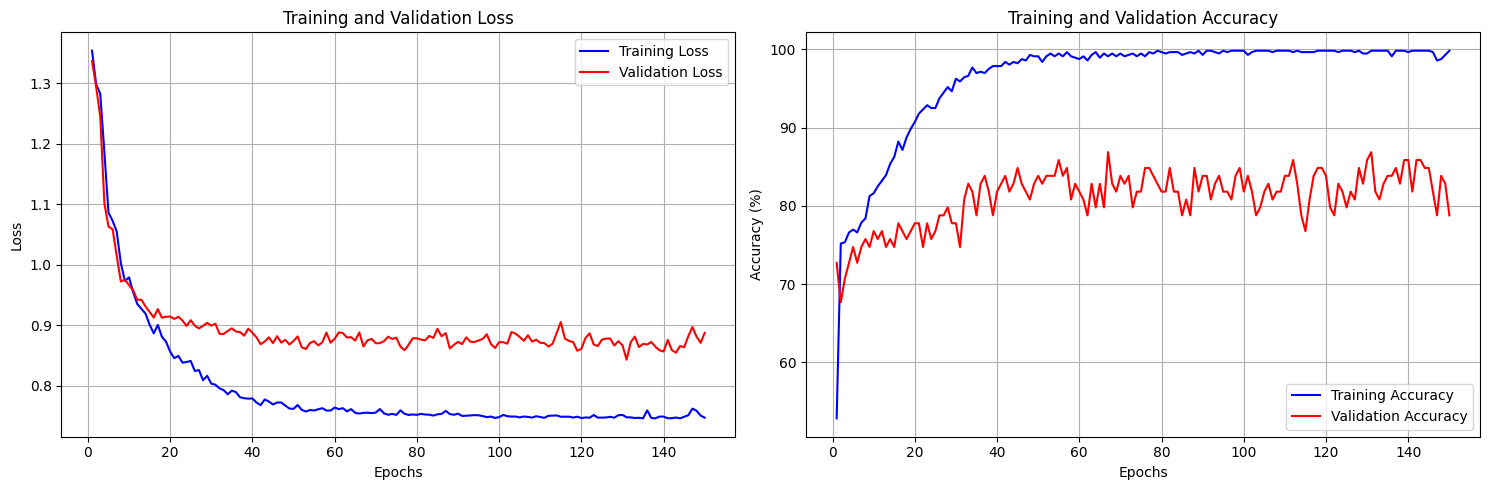

Training metrics plot saved as 'training_metrics.png'


In [12]:
plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies)


Per-class Accuracy:
--------------------------------------------------
Diagonal: 79.17% (19/24)
Horizontal: 91.67% (22/24)
Vertical: 76.47% (26/34)
Web: 70.59% (12/17)


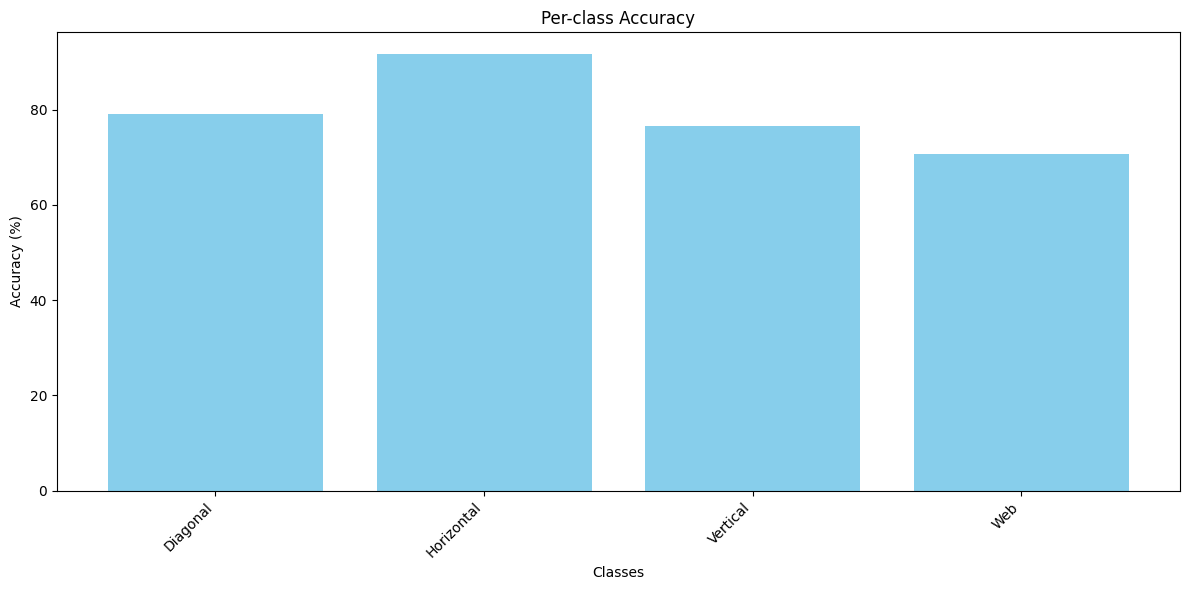

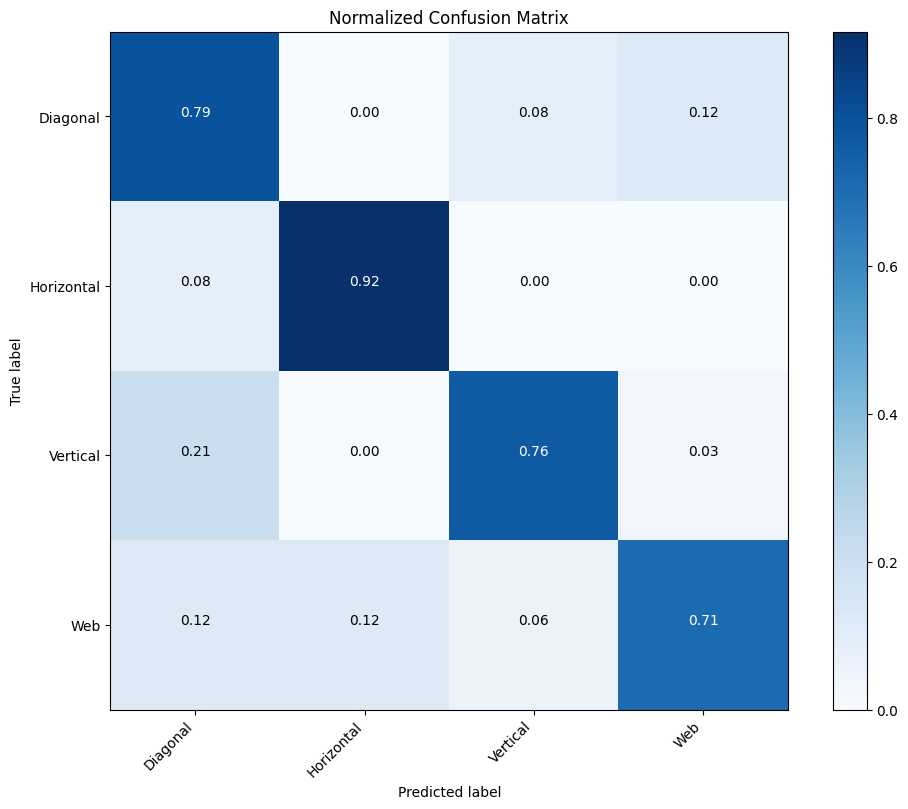

In [13]:
plot_evaluation_metrics(class_correct, class_total, confusion_matrix)

#### Generate prediction

In [6]:
import os
# Change this part to your path
test_folder_path="./test"        
csv_file_path="./submission_example.csv"
model_path="best_model.pth"
file_extension=".jpg"           


# Load CSV file
df = pd.read_csv(csv_file_path)
print(f"Loaded CSV with {len(df)} entries")

# Get column names
columns = df.columns.tolist()
first_col = columns[0]  # Image name column
second_col = columns[1]  # Empty column for predictions

# Load model
model_.load_state_dict(torch.load(model_path, map_location=device))
# model_ = trained_model
model_.to(device)
model_.eval()

imagenet_stats = [(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)]

# Set up transformation (same as we set up earlier in the dataloading part, put I put here again for clarity)
transform = transforms.Compose([
    transforms.CenterCrop((450, 270)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    # transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_stats[0], imagenet_stats[1])
])


for idx, row in tqdm(df.iterrows(), total=len(df)):
    try:
        img_name = str(row[first_col]).strip()
        
        img_path = os.path.join(test_folder_path, img_name + file_extension)
               
        # Process the image
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)
        
        # Predict
        with torch.no_grad():
            output = model_(img_tensor)
            _, predicted = torch.max(output.data, 1)
            predicted_idx = predicted.item()
        
        # Update CSV
        df.at[idx, second_col] = classes[predicted_idx]
        
    except Exception as e:
        print(f"Error with image {img_name}: {e}")

# Save updated CSV
df.to_csv(csv_file_path, index=False)
print(f"Updated CSV saved to {csv_file_path}")

Loaded CSV with 100 entries


100%|██████████| 100/100 [00:00<00:00, 102.53it/s]

Updated CSV saved to ./submission_example.csv


c:\Users\almon\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


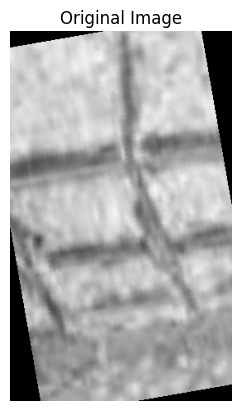

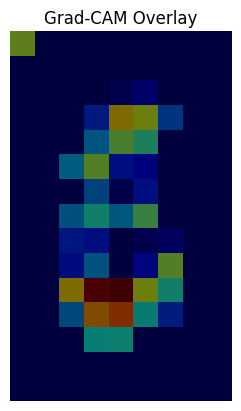

In [13]:
from torchvision.models.feature_extraction import create_feature_extractor
import torch.nn.functional as F

# Register hook containers
activations = None
gradients = None

# Hook functions
def forward_hook(module, input, output):
    global activations
    activations = output

def backward_hook(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0]

# Hook into the last conv layer of ResNet
target_layer = model_.layer4[-1].conv2
forward_handle = target_layer.register_forward_hook(forward_hook)
backward_handle = target_layer.register_backward_hook(backward_hook)

def generate_gradcam(img_tensor, label):
    global activations, gradients

    input_tensor = img_tensor.unsqueeze(0).to(device).requires_grad_()
    
    # Forward pass
    model_.eval()
    output = model_(input_tensor)
    class_idx = output.argmax(dim=1).item()

    # Backward pass
    model_.zero_grad()
    output[0, class_idx].backward()

    if gradients is None or activations is None:
        raise RuntimeError("Hooks did not capture gradients or activations.")

    # Compute weights and apply Grad-CAM
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=1).squeeze().cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-6
    return heatmap

# Visualize Grad-CAM on random val image
inv_norm = transforms.Normalize(
    mean=[-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
    std=[1/s for s in [0.229, 0.224, 0.225]]
)

def show_gradcam(img_tensor, heatmap):
    img_tensor = inv_norm(img_tensor.cpu())
    img_np = np.transpose(img_tensor.numpy(), (1, 2, 0))
    plt.imshow(img_np)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.title("Grad-CAM Overlay")
    plt.axis('off')
    plt.show()

def show_original(img_tensor):
    img_tensor = inv_norm(img_tensor.cpu())
    img_np = np.transpose(img_tensor.numpy(), (1, 2, 0))
    plt.imshow(img_np)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

# Run on one image
val_transform = transforms.Compose([
        transforms.RandomResizedCrop((450, 270)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_stats[0], imagenet_stats[1])
    ])
full_dataset = torchvision.datasets.ImageFolder(root=path_dataset, transform=val_transform)
sample_img, label = random.choice(full_dataset)
heatmap = generate_gradcam(sample_img, label)
show_original(sample_img)
show_gradcam(sample_img, heatmap)